In [1]:
# Import all dependencies

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
#from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
#tf.config.threading.set_intra_op_parallelism_threads(6)

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# read csv in the dataframea

df = pd.read_csv("../ane_energy/df_merged.csv",parse_dates=['dt_start_utc'],index_col='dt_start_utc')

In [5]:
# show if some nans in our dataframe

print(np.any(np.isnan(df)))

False


In [6]:
df.head()

,50Hertz_power_mw_x,DE_power_mw_x,DK_power_mw_x,DK1_power_mw_x,TTG_power_mw_x,total_pred_cons,Wasserkraft,Wind Onshore[MWh],Sonstige Erneuerbare[MWh],Kernenergie[MWh],...,rz_saldo_roll_diff_16_2,epex_diff,epex_roll_win8,epex_roll_win2,epex_roll_diff_16_2,fac_epex_rz_saldo,weekday,businessday,businesshours,rz_saldo_mwh_sign
dt_start_utc,,,,,,,,,,,,,,,,,,,,,
2021-01-01 06:15:00,915.0,2337.0,81.0,41.0,730.0,4104.0,287.0,552.0,56.0,2.036,...,21.2500,0.163778,39.865196,40.007385,0.151559,-966.090674,4,1,1,-1.0
2021-01-01 06:30:00,910.0,2342.0,81.0,41.0,738.0,4112.0,286.0,536.0,56.0,2.036,...,48.5000,0.163052,39.929604,40.171526,-0.083814,-3233.346434,4,1,1,-1.0
2021-01-01 06:45:00,906.0,2352.0,81.0,41.0,748.0,4128.0,286.0,505.0,57.0,2.039,...,20.5000,0.294637,40.054093,40.368019,-0.289428,1058.498157,4,1,1,1.0
2021-01-01 07:00:00,903.0,2363.0,84.0,52.0,759.0,4161.0,287.0,514.0,57.0,2.039,...,-46.1875,0.558532,40.259093,40.663019,-0.529428,2187.310000,4,1,1,1.0
2021-01-01 07:15:00,882.0,2361.0,84.0,52.0,777.0,4156.0,290.0,510.0,57.0,2.039,...,-69.5000,0.822428,40.565033,41.122681,-0.867957,3072.747225,4,1,1,1.0


In [7]:
# lets have a look about our data, how its distributed

df.describe()

,50Hertz_power_mw_x,DE_power_mw_x,DK_power_mw_x,DK1_power_mw_x,TTG_power_mw_x,total_pred_cons,Wasserkraft,Wind Onshore[MWh],Sonstige Erneuerbare[MWh],Kernenergie[MWh],...,rz_saldo_roll_diff_16_2,epex_diff,epex_roll_win8,epex_roll_win2,epex_roll_diff_16_2,fac_epex_rz_saldo,weekday,businessday,businesshours,rz_saldo_mwh_sign
count,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,...,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000
mean,3698.055922,10840.317546,1079.399318,883.551122,4517.622658,21018.946565,422.808293,139.321202,46.721663,1.850000,...,0.063487,0.002172,54.960827,54.966260,-0.018318,-741.250706,2.999075,0.711948,-0.167014,-0.062341
std,3276.629072,8662.920618,921.776306,768.672535,3664.402896,16497.380697,99.381445,279.490393,7.645216,0.179444,...,92.790250,2.010151,22.798248,23.085079,9.030273,6777.661726,2.007590,0.452869,0.985983,0.998084
min,0.000000,164.000000,38.000000,17.000000,74.000000,568.000000,245.000000,1.000000,36.000000,1.210000,...,-492.750000,-14.832536,-68.280946,-69.823217,-48.492249,-55005.470790,0.000000,0.000000,-1.000000,-1.000000
25%,1251.750000,4508.000000,349.000000,276.000000,1678.750000,8891.500000,349.000000,1.835750,39.000000,1.663000,...,-56.390625,-0.974278,44.322083,44.249851,-4.420974,-4154.239821,1.000000,0.000000,-1.000000,-1.000000
50%,2508.500000,7844.000000,771.000000,622.000000,3222.000000,15048.000000,385.000000,3.478000,45.000000,1.925000,...,-1.781250,-0.171360,55.409913,55.319164,1.362473,-316.794967,3.000000,1.000000,-1.000000,-1.000000
75%,5314.000000,14787.750000,1590.250000,1289.000000,6432.000000,28745.250000,512.000000,8.492250,54.000000,2.015000,...,56.062500,0.810108,67.811826,67.849164,5.154478,2889.001714,5.000000,1.000000,1.000000,1.000000
max,14576.000000,39567.000000,4217.000000,3459.000000,15683.000000,75105.000000,686.000000,999.000000,58.000000,2.052000,...,557.500000,15.350845,135.055446,139.949643,37.876499,42943.829639,6.000000,1.000000,1.000000,1.000000


In [8]:
#profile = ProfileReport(df, title="df :: Pandas Profiling Report", explorative=True)
#profile.to_file("Pandas_Report_epex_da_de.html")

In [9]:
# helps us to find and replace inappropriate characters

import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]


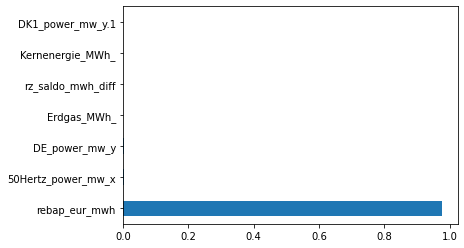

In [10]:
# Feature Importances

from numpy import loadtxt
from xgboost import XGBRegressor
from matplotlib import pyplot

model = XGBRegressor()
model.fit(df,df['rebap_eur_mwh'])

(pd.Series(model.feature_importances_, index=df.columns)
   .nlargest(7)
   .plot(kind='barh'));

In [11]:
# defined function which preprocesses the data suitable for forecasting

def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [12]:
# cut the last 48 Timestamps data for forecasting

validate = df.tail(48)
df.drop(df.tail(48).index,inplace=True)

In [13]:
# drop the columns we dont need

df_1 = df.drop("rebap_eur_mwh", axis= 1)

In [14]:
# MinMaxScaler to scale down the values. 
# The neural network converges sooner when it exposes the same scaled features and gives better accuracy

x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(df_1)
dataY = y_scaler.fit_transform(df[['rebap_eur_mwh']])

In [15]:
# As we are doing multiple-step forecasting, 
# let’s allow the model to see past 192 hours of data and forecast the 48 hrs after data; 
# for that, we set the horizon to 48.

hist_window = 192
horizon = 48
TRAIN_SPLIT = 10000
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [16]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[0.06277442 0.05514809 0.01028954 ... 1.         1.         0.        ]
 [0.06243139 0.05527498 0.01028954 ... 1.         1.         0.        ]
 [0.06215697 0.05552877 0.01028954 ... 1.         1.         1.        ]
 ...
 [0.37019759 0.29535822 0.17851161 ... 0.         0.         0.        ]
 [0.37795005 0.30226125 0.17851161 ... 0.         0.         0.        ]
 [0.38378156 0.30822526 0.20124432 ... 0.         0.         0.        ]]

 Target horizon
[[0.35199618]
 [0.35240457]
 [0.35570267]
 [0.3545361 ]
 [0.35453783]
 [0.34514839]
 [0.34259985]
 [0.34869118]
 [0.35984512]
 [0.34917539]
 [0.34989566]
 [0.3470473 ]
 [0.34709382]
 [0.34665097]
 [0.34705419]
 [0.36262801]
 [0.35950739]
 [0.35837355]
 [0.35870785]
 [0.3482535 ]
 [0.35875437]
 [0.35470325]
 [0.3586596 ]
 [0.35449819]
 [0.35479802]
 [0.35491864]
 [0.35626442]
 [0.35588188]
 [0.35497551]
 [0.35617482]
 [0.35580089]
 [0.35330233]
 [0.35546143]
 [0.35618343]
 [0.35546143]
 [0.3562851 ]
 [0.3

In [17]:
df.shape

(17244, 74)

In [18]:
# Prepare the training data and validation data using the TensorFlow data function, 
# which faster and efficient way to feed data for training.

BATCH_SIZE = 16
BUFFER_SIZE = 4

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


In [19]:
# Build and compile the model

lstm_multi = tf.keras.models.Sequential()
lstm_multi.add(tf.keras.layers.LSTM(150,input_shape=x_train_multi.shape[-2:],return_sequences=True))
lstm_multi.add(tf.keras.layers.Dropout(0.2)),
lstm_multi.add(tf.keras.layers.LSTM(units=100,return_sequences=False)),
lstm_multi.add(tf.keras.layers.Dropout(0.2)),
lstm_multi.add(tf.keras.layers.Dense(units=horizon)),
lstm_multi.compile(optimizer='adam', loss='mse')

In [20]:
# save model

model_path = r'\Chapter_7\LSTM_Multivariatex.h5"

In [21]:
# train the model

EVALUATION_INTERVAL = 150
EPOCHS = 150
history = lstm_multi.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])


Epoch 1/150
150/150 [==============================] - 13s 54ms/step - loss: 0.0111 - val_loss: 0.0011
Epoch 2/150
150/150 [==============================] - 5s 31ms/step - loss: 0.0031 - val_loss: 5.7189e-04
Epoch 3/150
150/150 [==============================] - 4s 30ms/step - loss: 0.0018 - val_loss: 2.8602e-04
Epoch 4/150
150/150 [==============================] - 5s 30ms/step - loss: 0.0021 - val_loss: 3.7018e-04
Epoch 5/150
150/150 [==============================] - 9s 63ms/step - loss: 0.0013 - val_loss: 3.4932e-04
Epoch 6/150
150/150 [==============================] - 4s 30ms/step - loss: 0.0010 - val_loss: 3.7355e-04
Epoch 7/150
150/150 [==============================] - 4s 30ms/step - loss: 7.3904e-04 - val_loss: 2.4319e-04
Epoch 8/150
150/150 [==============================] - 4s 29ms/step - loss: 0.0013 - val_loss: 3.8221e-04
Epoch 9/150
150/150 [==============================] - 5s 31ms/step - loss: 9.0125e-04 - val_loss: 2.2775e-04
Epoch 10/150
150/150 [===================

In [22]:
# Load the saved model

Trained_model = tf.keras.models.load_model(model_path)

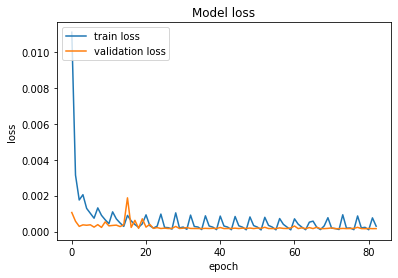

In [23]:
# plot our train and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [24]:
# Show the model architecture
Trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 192, 150)          134400    
_________________________________________________________________
dropout (Dropout)            (None, 192, 150)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 48)                4848      
Total params: 239,648
Trainable params: 239,648
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Prepare the testing data for the last 192 hrs and check the prediction against it
# by visualizing the actual and predicted values. 

data_val = x_scaler.fit_transform(df_1.tail(192))

In [26]:
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [27]:
Predicted_results = Trained_model.predict(val_rescaled)

In [28]:
Predicted_results

array([[0.35243702, 0.3522657 , 0.352112  , 0.3519914 , 0.351913  ,
        0.35220397, 0.3519487 , 0.35248524, 0.35275674, 0.3528773 ,
        0.35260463, 0.3518786 , 0.35170662, 0.3519992 , 0.35181   ,
        0.35239428, 0.35169026, 0.35148343, 0.35194772, 0.35262597,
        0.35276   , 0.3517593 , 0.35262033, 0.35224542, 0.35274258,
        0.3528556 , 0.35201126, 0.35248247, 0.3524141 , 0.35235056,
        0.35244286, 0.35280517, 0.35278368, 0.3523417 , 0.35268608,
        0.35278675, 0.35348374, 0.35309082, 0.3527854 , 0.35334504,
        0.35321778, 0.35271463, 0.35326537, 0.3524074 , 0.352598  ,
        0.35245466, 0.35322765, 0.35193884]], dtype=float32)

In [29]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [30]:
Predicted_results_Inv_trans

array([[46.56833 , 45.574024, 44.682106, 43.982166, 43.5273  , 45.21584 ,
        43.734497, 46.848167, 48.423763, 49.12336 , 47.541016, 43.327713,
        42.329605, 44.02748 , 42.929577, 46.320312, 42.234653, 41.03436 ,
        43.72879 , 47.66485 , 48.442616, 42.635384, 47.63216 , 45.456417,
        48.341614, 48.997448, 44.097527, 46.83208 , 46.43533 , 46.066593,
        46.602226, 48.704815, 48.580112, 46.015224, 48.013695, 48.597927,
        52.642773, 50.362564, 48.590145, 51.837852, 51.099342, 48.179382,
        51.37555 , 46.39641 , 47.50262 , 46.670715, 51.15659 , 43.67725 ]],
      dtype=float32)

In [31]:
# Finally, evaluate the result with standard performance metrics.

from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [32]:
# Results of the metrics

timeseries_evaluation_metrics_func(validate['rebap_eur_mwh'],Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is : 10537.429478832371
MAE is : 84.75476413408916
RMSE is : 102.65198234243881
MAPE is : 94.8334114073825
R2 is : -1.2854818837278117



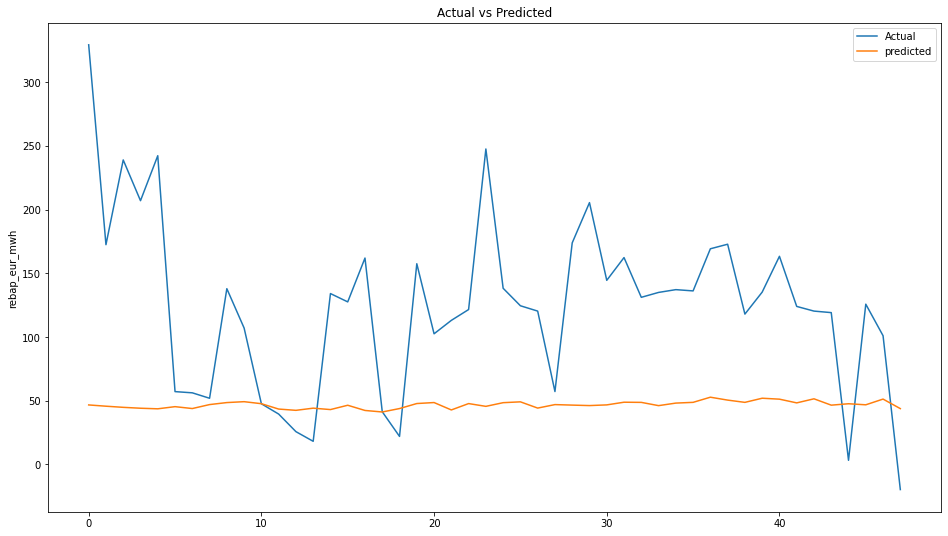

In [33]:
# Plot the actual vs predicted data

plt.plot( list(validate['rebap_eur_mwh']))
plt.plot( list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("rebap_eur_mwh")
plt.legend(('Actual','predicted'))
plt.show()